# save_square_fragm function

Saving random unique square fragments of an image (located inside or outside defined bounding box) as jpg. 

## The task

This little project is inspired by a recruitment task of a company that wished to remain anonymous. The task was to:
1. write a code that saves a specified number of random unique square fragments of a given image.
2. The fragments were to be located inside or outside defined bounding box (depending on a value of a parameter assigned). 
3. The fragments had to be smaller than the bounding box to be able to fit in it. 
4. The fragments were to be saved as jpg files in newly created output folder.
5. Before saving, the existing output folder was to be deleted with its content and created again.

A starting code provided by the company (requested not to be published here) was providing the input for the function to be created, containing: 
1. name of the output folder, as a string, 
2. value of  the parameter deciding if the fragments are to be located inside or outside the bounding box, as a boolean value,
3. custom definition of a bounding box with negative height, as a tuple (dealt by me as ((x1,y2),(x2,y1))),
4. number of square fragments to be saved, as an integer,
5. length of the side of the square fragments, as an integer,
6. the image to work on, as an JpegImageFile, Mode:RGB.

Here I present modified version of my solution adapted to process MRI (Magnetic Resonance Imaging) images in FDF format (native for Agilent MRI scanners). The current version:
1. takes as an input the FDF image path instead of preloaded jpg image,
2. can be easily modified to work on any image format,
3. allows for optional visual verification of the image with overlaid bounding box.

## Sample data

The sample data are MRI images of a bumblebee fixed in 5% glutaraldehyde solution. The imaging was performed on a 9.4 T horizontal bore Agilent MRI scanner using a 40 mm diameter millipede coil for transmission and reception. The images were acquired using Gradient Echo Multi Slice imaging sequence (slice dimensions: 25 mm x 25 mm; slice thickness: 0.1 mm; data matrix: 1024 x 1024; TE = 6.79 ms, TR = 350 ms; flip angle: 40 deg; 36 averages). 


## The input parameters

In [1]:
img_path = "bumblebeeMRI/slice002.fdf"           # Path to the FDF image of choice: img_path [str]
bb = ((440, 930), (825, 35))                     # Bounding box: bb [tuple, ((x1,y2),(x2,y1))]
vv = 1                                           # Show the image with the bounding box for visual verification: vv [bool]
N = 10                                           # Number of square fragments to create: N [int]
a = 100                                          # Length of the side of the square fragments: a [int]
inner = 1                                        # Position of the squares in relation to the bonding box: inner [bool]
out_folder = "square_fragm"                      # Output folder: out_folder [str]

## The function

In [2]:
import itk
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import itertools
import random
import numpy as np
import cv2
import os
import shutil

def save_square_fragm(img_path, bb, vv, N, a, inner, out_folder):
    """
    Saves random unique square fragments of FDF image (located inside or outside defined bounding box) as jpg.
    Input: 
        image location: img_path [str],
        bounding box: bb [tuple, ((x1,y2),(x2,y1))],
        visual verification: vv [bool],
        number of square fragments: N [int],
        length of the side of the square fragments: a [int],
        position of the squares in relation to the bonding box: inner [bool],
        output folder: out_folder [str].
    """
    # FDF image import
    imageio = itk.FDFImageIO.New()
    img = itk.imread(img_path, imageio=imageio)
    img = np.array(img)
    del img_path
    
    # Image and bounding box visual veryfication
    if vv:
        plt.rcParams['figure.dpi'] = 200
        figure, image = plt.subplots()
        image.imshow(img, cmap=plt.get_cmap('gray'))
        w = bb[1][0] - bb[0][0]
        h = bb[1][1] - bb[0][1]
        bb_rect = Rectangle(bb[0], w, h, linewidth=0.5, edgecolor='cyan', facecolor='none')
        image.add_patch(bb_rect)
        plt.title("Image and bounding box - visual veryfication")
        plt.show()
    del vv
        
    # length of the side of the square fragments must be smaller than the bounding box 
    if min([bb[1][0] - bb[0][0], bb[0][1] - bb[1][1]]) >= a:
        
        if inner:            
            # N squares have to fit inside the bounding box:
            N_max = (bb[0][1] - bb[1][1] - a + 2) * (bb[1][0] - bb[0][0] - a + 2)
            if N > N_max:
                print(f"{N} unique squares of size {a} will not fit into the bounding box.")
            
            else:
                # list of allowed locations of upper left corners of the squares
                A = range(bb[0][0], bb[1][0] - a + 2)
                B = range(bb[1][1], bb[0][1] - a + 2)
                PickList = list(itertools.product(A, B))
                
                # input image and output folder preparation                
                img = img/(img.max()/255.0)                              # because FDFs are not scalled 0-255
                shutil.rmtree(out_folder, ignore_errors=True)            # removing residual output folder with content
                os.makedirs(out_folder)                                  # creating new output folder
                
                # positions of the squares and saving square fragments of the image
                i = 0
                squares = random.sample(PickList, N)
                for square in squares:
                    roi = img[square[1] : square[1] + a, square[0] : square[0] + a]
                    cv2.imwrite(f"{out_folder}/{i+1}.jpg", roi)            
                    i = i + 1
        
        else:
            # list of allowed locations of upper left corners of the squares for the image size and "a"
            A = range(0, np.shape(img)[0]- a + 1)
            B = range(0, np.shape(img)[1]- a + 1)
            C = list(itertools.product(A, B))
            # list of locations excluded by bounding box
            D = range(bb[0][0] - a + 1, bb[1][0] + 1)
            E = range(bb[1][1] - a + 1, bb[0][1] + 1)
            F = list(itertools.product(D, E))
            # resulting list of allowed locations of upper left corners of the squares
            # operation on sets, because depending on the position of the box, 
            # there may be elements in F that do not appear in C (excluded by "a")
            PickList = list(set(C) - set(F))
            
            # N squares have to fit inside the selected image region:            
            if N > len(PickList):
                print(f"{N} unique squares of size {a} will not fit into the selected image region.")
                
            else:                
                # input image and output folder preparation                
                img = img/(img.max()/255.0)                              # because FDFs are not scalled 0-255
                shutil.rmtree(out_folder, ignore_errors=True)            # removing residual output folder with content
                os.makedirs(out_folder)                                  # creating new output folder
                
                # positions of the squares and saving square fragments of the image
                i = 0
                squares = random.sample(PickList, N)
                for square in squares:
                    roi = img[square[1] : square[1] + a, square[0] : square[0] + a]
                    cv2.imwrite(f"{out_folder}/{i+1}.jpg", roi)            
                    i = i + 1
    else:
        print('"a" is too big for the bounding box.')

## Calling the function

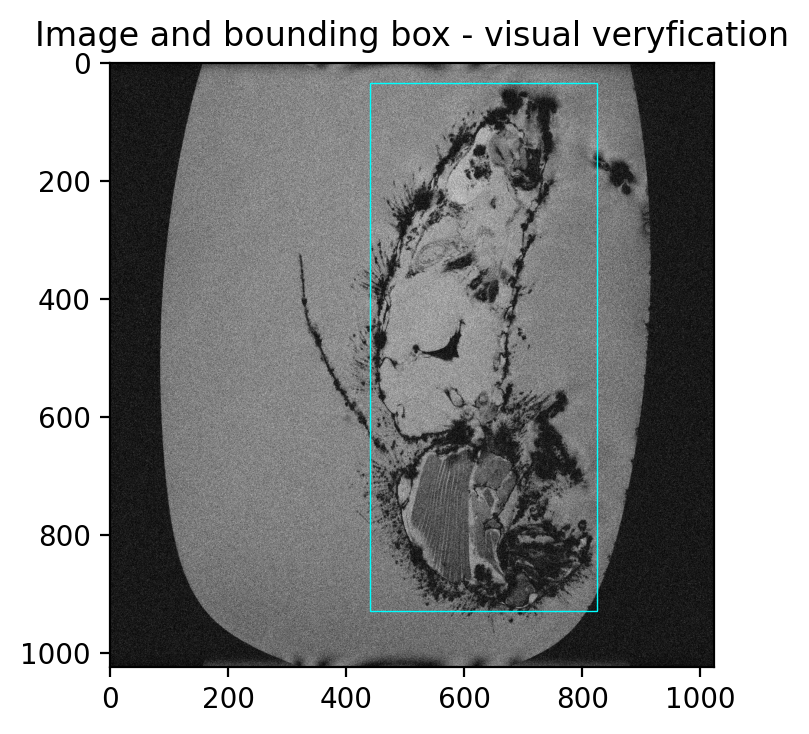

In [4]:
save_square_fragm(img_path, bb, vv, N, a, inner, out_folder)

## The square fragments saved
#### List of files in the output folder

In [5]:
os.listdir(out_folder)

['1.jpg',
 '10.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

#### The first 3 images as an example of the output

(<AxesSubplot:>,
 (-0.5, 99.5, 99.5, -0.5))

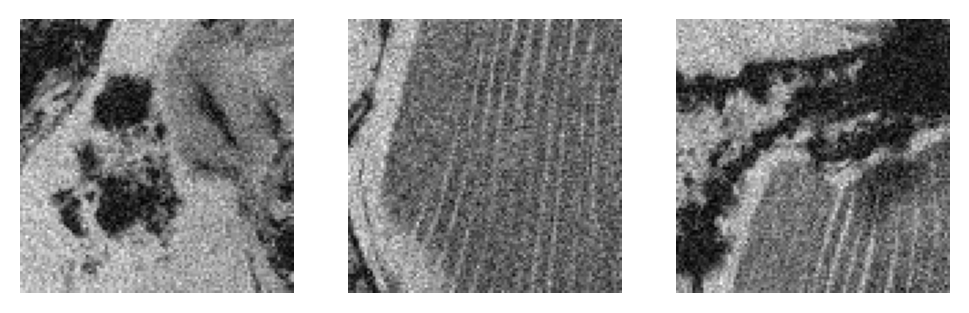

In [6]:
from PIL import Image
fig = plt.figure()
fig.add_subplot(1, 3, 1), plt.imshow(Image.open(f'{out_folder}/1.jpg'), cmap=plt.get_cmap('gray')), plt.axis('off')
fig.add_subplot(1, 3, 2), plt.imshow(Image.open(f'{out_folder}/2.jpg'), cmap=plt.get_cmap('gray')), plt.axis('off')
fig.add_subplot(1, 3, 3), plt.imshow(Image.open(f'{out_folder}/3.jpg'), cmap=plt.get_cmap('gray')), plt.axis('off')